# 2018.11.01: Network inference from time series of cartegorical variables
## Vipul's update

In [1]:
import sys,os
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# setting parameter:
np.random.seed(1)

n = 10 # number of positions
m = 5 # number of values at each position
l = 4.*((n*m)**2) # number of samples
#l = 500

l = int(l)
g = 2.

In [3]:
def itab(n,m):    
    i1 = np.zeros(n)
    i2 = np.zeros(n)
    for i in range(n):
        i1[i] = i*m
        i2[i] = (i+1)*m

    return i1.astype(int),i2.astype(int)

i1tab,i2tab = itab(n,m)

In [4]:
# generate coupling matrix w0:
def generate_coupling(n,m,g):
    nm = n*m
    w = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))
    
    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
        w[i1:i2,:] -= w[i1:i2,:].mean(axis=0)            

    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
        w[:,i1:i2] -= w[:,i1:i2].mean(axis=1)[:,np.newaxis]            
        
    return w

In [5]:
w0 = generate_coupling(n,m,g)

In [6]:
# 2018.10.27: generate time series by MCMC
def generate_sequences(w,n,m,l): 
    #print(i1tab,i2tab)
    
    # initial s (categorical variables)
    s_ini = np.random.randint(0,m,size=(l,n)) # integer values
    #print(s_ini)

    # onehot encoder 
    enc = OneHotEncoder(n_values=m)
    s = enc.fit_transform(s_ini).toarray()
    #print(s) 

    ntrial = 200

    for t in range(l-1):
        h = np.sum(s[t,:]*w[:,:],axis=1)
        for i in range(n):
            i1,i2 = i1tab[i],i2tab[i]
                
            k = np.random.randint(0,m)              
            for itrial in range(ntrial):            
                k2 = np.random.randint(0,m)                
                while k2 == k:
                    k2 = np.random.randint(0,m)
                               
                if np.exp(h[i1+k2]- h[i1+k]) > np.random.rand():
                    k = k2
            
            s[t+1,i1:i2] = 0.
            s[t+1,i1+k] = 1.
            
    return s            

In [7]:
s = generate_sequences(w0,n,m,l) 

In [8]:
def fit_couplings(s,n,m):
    x = s[:-1]
    y = s[1:]

    l = x.shape[0]

    nm = n*m
    nloop = 10

    wini = np.random.normal(0.0,1./np.sqrt(nm),size=(nm,nm))

    w_infer = np.zeros((nm,nm))
    for i in range(n):
        print('i:',i)

        i1,i2 = i1tab[i],i2tab[i]

        w01 = w0[i1:i2,:]

        #----------------------------------------------------------------
        # covariance [ia,ib] for only sequences that have either a or b
        cab_inv = np.empty((m,m,nm,nm))
        eps = np.empty((m,m,l))
        for ia in range(m):
            for ib in range(m):
                if ib != ia:
                    # eps[t] = s[t+1,ia] - s[t+1,ib] 
                    eps[ia,ib,:] = y[:,i1+ia] - y[:,i1+ib]

                    which_ab = eps[ia,ib,:] !=0.                    
                    sab = x[which_ab]                    

                    # ----------------------------
                    sab_av = np.mean(sab,axis=0)
                    dsab = sab - sab_av
                    cab = np.cov(dsab,rowvar=False,bias=True)
                    cab_inv[ia,ib,:,:] = linalg.pinv(cab,rcond=1e-15)
                    #print(c_inv)
        # ---------------------------------------------------------------

        w = wini[i1:i2,:].copy()
        cost = np.full(nloop,100.)    
        for iloop in range(1,nloop):
            h = np.dot(x,w.T)

            # stopping criterion --------------------
            p = np.exp(h)
            p_sum = p.sum(axis=1)

            for k in range(m):
                p[:,k] = p[:,k]/p_sum[:]

            cost[iloop] = ((y[:,i1:i2] - p[:,:])**2).mean()
            #if cost[iloop] >= cost[iloop-1]: break  

            #---------------------------------------- 
            for ia in range(m):
                wa = np.zeros(nm)                
                for ib in range(m):
                    if ib != ia:

                        which_ab = eps[ia,ib,:] !=0.

                        eps_ab = eps[ia,ib,which_ab]
                        sab = x[which_ab]

                        # ----------------------------
                        sab_av = np.mean(sab,axis=0)
                        dsab = sab - sab_av

                        h_ab = h[which_ab,ia] - h[which_ab,ib]                    
                        ha = np.divide(eps_ab*h_ab,np.tanh(h_ab/2.), out=np.zeros_like(h_ab), where=h_ab!=0)                        

                        dhds = (ha - ha.mean())[:,np.newaxis]*dsab
                        dhds_av = dhds.mean(axis=0)

                        wa += cab_inv[ia,ib,:,:].dot(dhds_av)

                w[ia,:] = wa/m

            #mse = ((w01-w)**2).mean()
            #slope = (w01*w).sum()/(w01**2).sum()                
            #print(i,iloop,mse,slope,cost[iloop])
            #print(i,iloop,cost[iloop])
            
        w_infer[i1:i2,:] = w   
    return w_infer

In [9]:
w = fit_couplings(s,n,m)

('i:', 0)
('i:', 1)
('i:', 2)
('i:', 3)
('i:', 4)
('i:', 5)
('i:', 6)
('i:', 7)
('i:', 8)
('i:', 9)


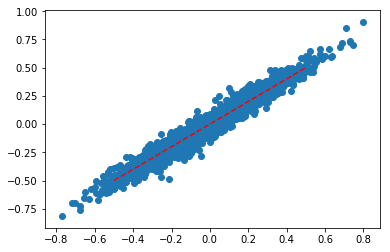

In [10]:
plt.scatter(w0,w)
plt.plot([-0.5,0.5],[-0.5,0.5],'r--')

In [11]:
mse = ((w0-w)**2).mean()
print('mse:',mse)

('mse:', 0.0028233697229810696)
